# **Проект** Выявление параметров "успешной" игры для интернет-магазина «Стримчик»

**Цель проекта** - выявить определяющие успешность игры закономерности

**Задачи:**
- Прочитать и проверить предоставленный файл
- Сделать предобработку предоставленных данных
- Провести анализ данных (оценить средную длительность поездки, среднюю дальность поездки, соотношение пользователей с и без подписки, средний возраст пользователя
- Составить портрет пользователя по регионам
- Проверить ряд гипотез

<font size='5'>
    Библиотеки для анализа
</font>

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st

<font size='5'>
    Константы
</font>

In [87]:
RANDOM_STATE = 486

## Чтение файла и первичный анализ данных

Начнем с загрузки и первичного анализа данных (вывод общей информации о фрейме).

In [88]:
try:
    # Считываем данные
    raw_data = pd.read_csv('https://code.s3.yandex.net/datasets/games.csv')
    # Выводим пять случайных строк для проверки корректности чтения
    print('Даннные были загружены успешно!\n\nПять случайных строк фрейма:')
    try:
        display(raw_data.sample(n=5, random_state=789))
    except:
        display(raw_data.head())
    # Выведем размер фрейма
    print(f'\nФрейм состоит из {raw_data.shape[1]} признаков и {raw_data.shape[0]} объектов')

    # Выводим общую информацию о фрейме
    print('\nОбщая информация о фрейме:')
    raw_data.info()
except:
    print('Ошибка загрузки данных! Проверь корректность пути к файлу.')

Даннные были загружены успешно!

Пять случайных строк фрейма:


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
8811,World Series Baseball 2K3,XB,2003.0,Sports,0.11,0.03,0.00,0.01,89.0,8.6,E
1568,WWE '13,X360,2012.0,Action,0.72,0.44,0.00,0.11,78.0,8,T
3972,Star Wars: Jedi Starfighter,PS2,2002.0,Simulation,0.24,0.19,0.00,0.06,81.0,8.3,T
1446,Test Drive,PS2,2002.0,Racing,0.95,0.21,0.01,0.18,73.0,7.4,T
9199,Dino Crisis 3,XB,2003.0,Action,0.08,0.03,0.03,0.00,51.0,4.1,M



Фрейм состоит из 11 признаков и 16715 объектов

Общая информация о фрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


**Замечания:** 
- В 6 признаках (Name, Year_of_Release, Genre, Critic_Score, User_Score, Rating) присутствуют пустые значение, которые необходимо будет обработать.
- Стоит преобраховать данные в столбцах Year_of_Release и User_Score.

Пропуски в следующих признаках связаны с:
- **Name, Year_of_Release, Genre** - потеря данных/техническая ошибка
- **Critic_Score, User_Score, Rating** - нет данных вообще, не выставлялись оценки

## Предобработка данных
Данный блок начнем с переименования столбцов, так как столбцы названы неудобно.

In [89]:
raw_data.columns = raw_data.columns.str.lower()
# Проверка
raw_data.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

Следующим шагом преобразуем данные в двух признаков. Начну с признака year_of_release. Значения данного признака преобразуем к целочисленным

In [90]:
try:
    raw_data['year_of_release'] = raw_data['year_of_release'].astype('int')
except:
    print('Есть пустые значения. Стоить обработать сначала их')

Есть пустые значения. Стоить обработать сначала их


Проверим столбец на пустоты

In [91]:
raw_data['year_of_release'].isna().sum()

269

В фрейме присутствуют игры, у которых не указан год издания. Мы можем заменить такие значения годом издания той же игры, только на другой платформе. Это может дать нам небольшею погрешность, если, в действительности игра была выпущена в другом году на другой платформе, однако сохраним часть данных. Для полной коррекности стоит дополнить фрейм столбцами с наименованием игры и платформы в нижнем регистре

In [92]:
# Наименование игры
raw_data['name_lowered'] = raw_data['name'].str.lower()
# Проверка
raw_data['name_lowered'].sample(5, random_state=RANDOM_STATE)

12103      suzumiya haruhi no gekidou
3506                    madden nfl 06
12522    summon night 6: lost borders
12457          giants: citizen kabuto
7762                    new love plus
Name: name_lowered, dtype: object

In [93]:
# Аналогично
raw_data['platform_lowered'] = raw_data['platform'].str.lower()
# проверка
raw_data['platform_lowered'].sample(5, random_state=RANDOM_STATE)

12103    wii
3506      gc
12522    psv
12457    ps2
7762     3ds
Name: platform_lowered, dtype: object

С помощью цикла найдем игры с пустым годом издания и заменим пустые значения на первый в списке год издания одноименной игры

In [94]:
# Берем строки с пустым годом издания, вытаскиваем из обработанного столбца наименований все уникальные названия 
for game_name in raw_data.query('year_of_release.isna()')['name_lowered'].unique():
    # Заменяем пустоты на первое значение в списке одноименных игр
    raw_data.loc[(raw_data['year_of_release'].isna()) & (raw_data['name_lowered'] == game_name), 'year_of_release'] = \
    raw_data.sort_values(by='year_of_release', ascending=True).loc[raw_data['name_lowered'] == game_name, 'year_of_release'].iloc[0]
# Проверка
raw_data['year_of_release'].isna().sum()

146

Осталось немного пустых значений. Такие значения придется удалить

In [95]:
filtered_data = raw_data.query('year_of_release > 0')
# Проверка
filtered_data['year_of_release'].isna().sum()

0

Теперь приведем столбец к типу целых чисел

In [96]:
filtered_data['year_of_release'] = filtered_data['year_of_release'].astype('int')
# Проверка
print('Тип признака "year_of_release":', filtered_data['year_of_release'].dtype)

Тип признака "year_of_release": int32


C:\Users\Александр\AppData\Local\Temp\ipykernel_7696\3414545341.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['year_of_release'] = filtered_data['year_of_release'].astype('int')


Данные были успешно заменены. Сейчас стоит заменить значения столбца "user_score". Как следует из типа данных этой колонки, в нем содержатся строковые значения. Также в описании данных говорится, что в колонке содержатся значения "tbd", что означает - данные еще не занесены.Такие значения стоит записать как пустоты

In [97]:
filtered_data.loc[filtered_data['user_score']=='tbd', 'user_score'] = np.NaN
# Проверка
filtered_data.loc[filtered_data['user_score']=='tbd', 'user_score'].count()

0

Теперь переведем тип данных в столбце на тип float

In [98]:
filtered_data['user_score'] = filtered_data['user_score'].astype('float')
# Проверка
filtered_data['user_score'].head()

C:\Users\Александр\AppData\Local\Temp\ipykernel_7696\3576930513.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['user_score'] = filtered_data['user_score'].astype('float')


0    8.0
1    NaN
2    8.3
3    8.0
4    NaN
Name: user_score, dtype: float64

Замена прошла успешно

Проверим кол-во дубликатов игр (совпадение должно быть и в платформе и в наименовании)

In [99]:
filtered_data[['name_lowered', 'platform_lowered']].duplicated().sum()

5

Теперь стоит проверить, отличаются ли рейтинги и годы издания (так как это возможно одноименный ремастер). Выведем строчки с дубликатами

In [100]:
filtered_data[filtered_data[['name_lowered', 'platform_lowered']].duplicated(keep=False)]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,name_lowered,platform_lowered
604,Madden NFL 13,PS3,2012,Sports,2.11,0.22,0.00,0.23,83.0,5.5,E,madden nfl 13,ps3
659,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN,NaN,gen
1190,Need for Speed: Most Wanted,X360,2012,Racing,0.62,0.78,0.01,0.15,83.0,8.5,T,need for speed: most wanted,x360
1591,Need for Speed: Most Wanted,X360,2005,Racing,1.00,0.13,0.02,0.10,83.0,8.5,T,need for speed: most wanted,x360
1745,Sonic the Hedgehog,PS3,2006,Platform,0.41,0.06,0.04,0.66,43.0,4.1,E10+,sonic the hedgehog,ps3
4127,Sonic the Hedgehog,PS3,1991,Platform,0.00,0.48,0.00,0.00,43.0,4.1,E10+,sonic the hedgehog,ps3
5972,Need for Speed: Most Wanted,PC,2005,Racing,0.02,0.23,0.00,0.04,82.0,8.5,T,need for speed: most wanted,pc
11715,Need for Speed: Most Wanted,PC,2012,Racing,0.00,0.06,0.00,0.02,82.0,8.5,T,need for speed: most wanted,pc
14244,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN,NaN,gen
16230,Madden NFL 13,PS3,2012,Sports,0.00,0.01,0.00,0.00,83.0,5.5,E,madden nfl 13,ps3


- По фрейму видно, что есть повторяющиеся игры на тех же платформах, лишь с разными годами издания - такие игры удалить не можем, так как это могут быть оригинал и ремастер игры
- Также есть и строка с различием лишь в продажах по регионам - игра "Madden NFL 13". В таком случае стоит объединить продажи игры в первую строку и удалить вторую
- Игру без названия можем сразу исключить из данных

Начнем с удаления

In [101]:
filtered_data = filtered_data.query('not name.isna()')
# Проверка
filtered_data['name'].isna().sum

<bound method Series.sum of 0        False
1        False
2        False
3        False
4        False
         ...  
16710    False
16711    False
16712    False
16713    False
16714    False
Name: name, Length: 16567, dtype: bool>

Теперь обработаем дублирующуюся строку

In [102]:
filtered_data = (
    # Выделяем группы с уникальным набором наименования, платформы и годом издания
    filtered_data.groupby(['name_lowered', 'platform_lowered', 'year_of_release'])
    # Для всех качественных параметров мы выделяем первое появления
    # Для количественных - сумму (к таким относятся параметры продаж)
                 .agg(
                    {
                        'name': 'first', 
                        'platform': 'first',
                        'genre': 'first',
                        'na_sales': 'sum',
                        'eu_sales':'sum',
                        'jp_sales':'sum',
                        'other_sales': 'sum',
                        'critic_score':'first',
                        'user_score':'first',
                        'rating':'first'
                    }
    # Обновляем индекс
                ).reset_index()
    # Удаляем технические колонки (для красоты)
                 .drop(columns=['name_lowered', 'platform_lowered'])
)

# Проверка
filtered_data.head()

,year_of_release,name,platform,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,2016,Beyblade Burst,3DS,Role-Playing,0.00,0.00,0.03,0.00,NaN,NaN,None
1,2015,Fire Emblem Fates,3DS,Role-Playing,0.81,0.23,0.52,0.11,NaN,NaN,None
2,2013,Frozen: Olaf's Quest,3DS,Platform,0.27,0.27,0.00,0.05,NaN,NaN,None
3,2013,Frozen: Olaf's Quest,DS,Platform,0.21,0.26,0.00,0.04,NaN,NaN,None
4,2016,Haikyu!! Cross Team Match!,3DS,Adventure,0.00,0.00,0.04,0.00,NaN,NaN,None


Обработаем пустоты в столбцах. Выведем кол-во пустот в столбцах

In [103]:
filtered_data.isna().sum()

year_of_release       0
name                  0
platform              0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8492
user_score         9027
rating             6699
dtype: int64

Есть гипотеза, что оценка критиков (значение столбца "critic_score") и/или оценка пользователей (значение столюца "user_score") прямо зависят от общих продаж. Если гипотеза подтвердится, то мы можем заполнить пустые значения через коэффициент корреляции.<br>Для этого стоит сначала создать столбец общих продаж. Для этого сложим значения столбцов "na_sales", "eu_sales" и "jp_sales"

In [104]:
filtered_data['total_sales'] = filtered_data['na_sales'] + \
                               filtered_data['eu_sales'] + \
                               filtered_data['jp_sales'] + \
                               filtered_data['other_sales']
# Проверка
filtered_data['total_sales'].head()

0    0.03
1    1.67
2    0.59
3    0.51
4    0.04
Name: total_sales, dtype: float64

Теперь выведем коэффициент корреляции 

In [105]:
print('Коэф корреляции между общими продажами и оценкой критиков:', filtered_data['total_sales'].corr(filtered_data['critic_score']))
print('Коэф корреляции между общими продажами и оценкой пользователей:', filtered_data['total_sales'].corr(filtered_data['user_score']))

Коэф корреляции между общими продажами и оценкой критиков: 0.24530249647422014
Коэф корреляции между общими продажами и оценкой пользователей: 0.08816605972235514


Предположение не подтвердилось. Заполнить пустые значения в этих столбцах заменить (с помощью текущего набора данных) нельзя.


Проверим распределение рейтинга игры. В первую очередь следует заменить неактуальные и смежные рейтинги более общими и актуальными:

In [106]:
# AO -> M
filtered_data.loc[filtered_data['rating'] == 'AO', 'rating'] = 'M'

# E10+ -> T
filtered_data.loc[filtered_data['rating'] == 'E10+', 'rating'] = 'T'

# EC, K-A -> E
filtered_data.loc[(filtered_data['rating'] == 'EC') | (filtered_data['rating'] == 'K-A'), 'rating'] = 'E'

Следует проверить гипотезу, что играм определенного жанра чаще выставляют одинаковый рейтинг. Следует получить общее количество игр с в разрезе каждого рейтинга и жанра.

In [107]:
filtered_data.pivot_table(
    index='genre',
    columns='rating',
    values='name',
    aggfunc='count'
).fillna(0)

rating,E,M,RP,T
genre,,,,
Action,415.0,605.0,0.0,1156.0
Adventure,161.0,98.0,0.0,182.0
Fighting,8.0,49.0,0.0,379.0
Misc,459.0,13.0,0.0,399.0
Platform,354.0,3.0,0.0,205.0
Puzzle,288.0,0.0,0.0,52.0
Racing,581.0,18.0,1.0,265.0
Role-Playing,83.0,161.0,0.0,527.0
Shooter,47.0,562.0,0.0,400.0


Можно сделать вывод, что рейтинг игр **не зависит** от жанра игры, так как на вышепредставленной таблице не видны четко доминирующие рейтинги в определенных жанрах

Заменить пустоты рейтинга (так как это категориальный параметр) можно лишь на **техническое** NR - NoRating (нет рейтинга)

In [108]:
filtered_data['rating'] = filtered_data['rating'].fillna('NR')
# Проверка
filtered_data['rating'].isna().sum()

0

**Итог:**
- Мы заменили значения в двух столбцах (привели год выпуска к целочисленному типу, оценку пользователей к численному типу)
- Удалили строки с пустыми значениями наименования и жанра игры
- Заполнили частично пустые значения года издания
- Пустые значения могут быть связаны с:<br>
    -- год издания: техническая ошибка, данные не были собраны/сохранены<br>
    -- Оценка критиков/пользователей - не были собраны, данных просто нет, техническая ошибка<br>
    -- рейтинг игры - аналогично оценке

## Исследовательский анализ данных

Посчитаем общее количество выпущенных игр в разрезе годов. Выведем график

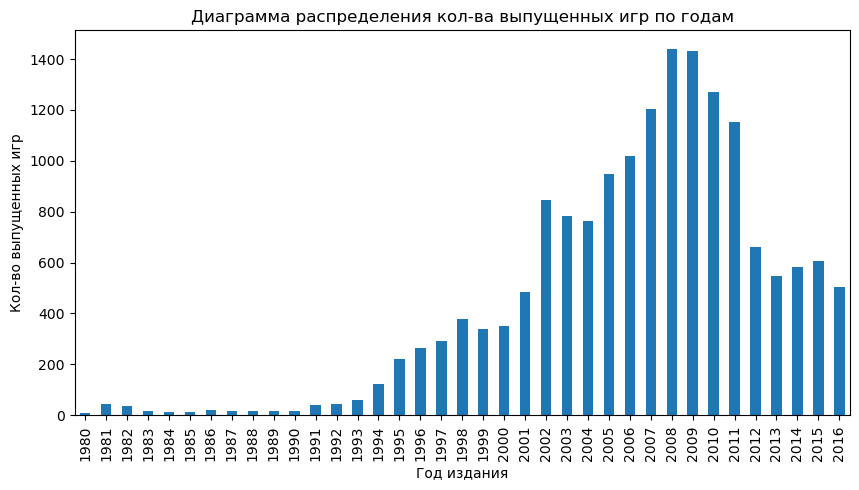

In [109]:
(
    filtered_data['year_of_release']
        .value_counts()
        .sort_index()
        .plot(kind="bar",
              title='Диаграмма распределения кол-ва выпущенных игр по годам',
              figsize=(10, 5),
              ylabel='Кол-во выпущенных игр',
              xlabel='Год издания')
)

plt.show()

По графику видно, что наибольшее число игр было выпущено в 2008 году. Также видна тенденция к росту кол-ва выпускаемых игр с 90ые по 10ые года, затем кол-во игр выпускаемых в последующие года снизилось<br>
Сокращением кол-ва платформ и, думаю, переход на ААА игры, которые требуют больше ресурсов и времени на создания. **Эта тенденция заметна с 2009 года**. Либо это связано с развитием мобильного гейминга<br>
Так как до 1990 года кол-во выпущенных игр не так высоко, можем исключить из выборки эти года

In [110]:
filtered_data = filtered_data.query('year_of_release >= 1990')

С помощью группировки мы построим общий график для распределения суммарных продаж на каждой платформе в разрезе годов, чтобы оценить общие данные по продажам в разрезе платформ и годов

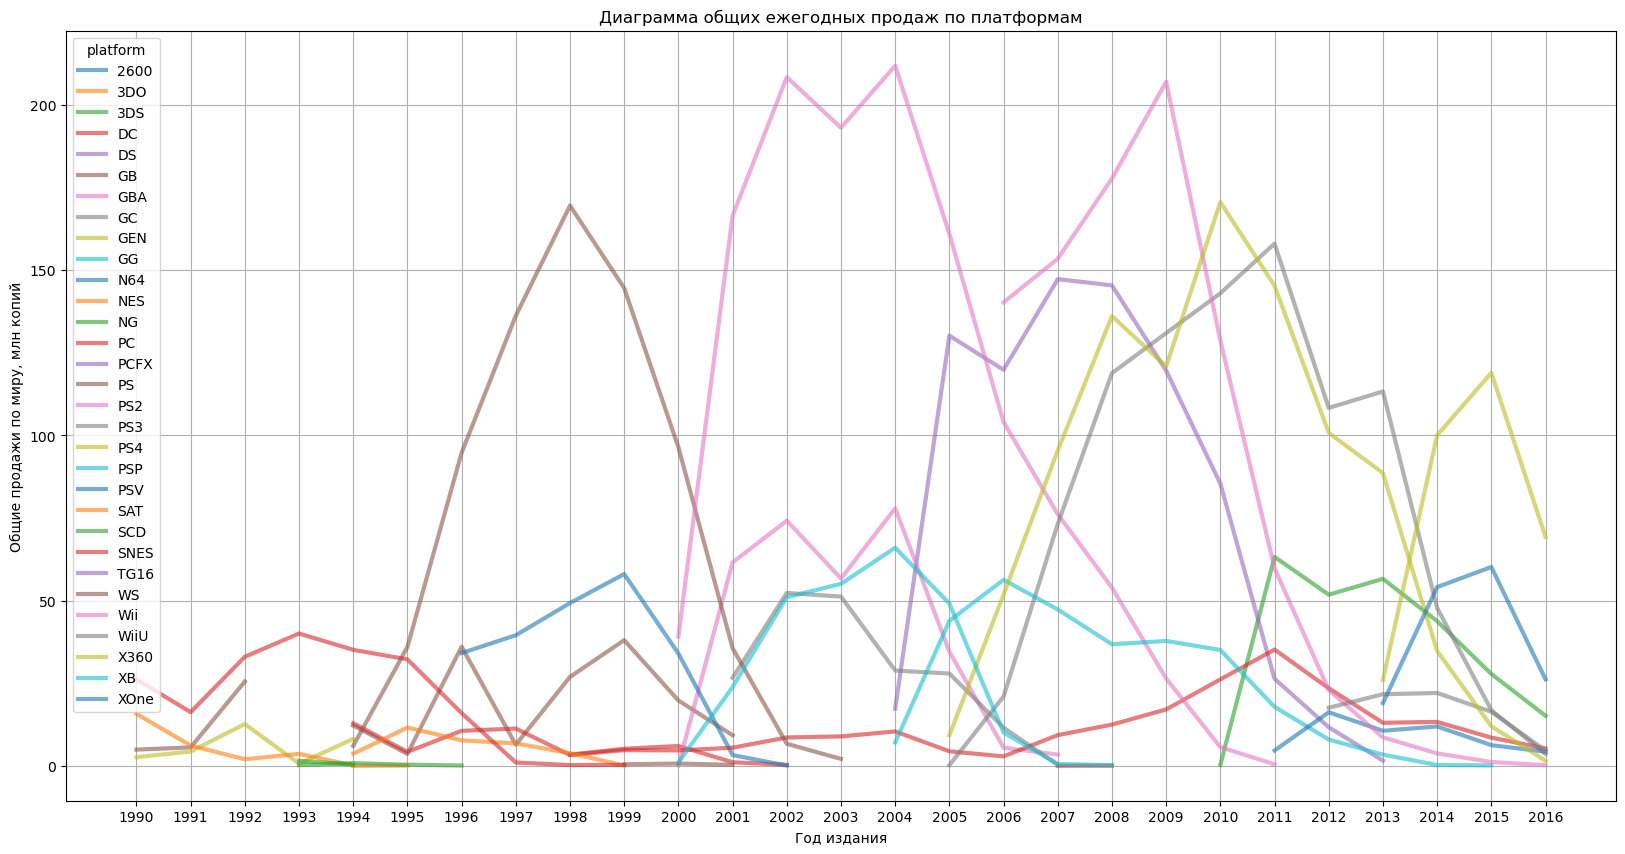

In [111]:
(
    filtered_data.groupby(['year_of_release', 'platform'])
                 ['total_sales']
                 .sum()
                 .unstack()
                 .plot(
                     kind="line",
                     title='Диаграмма общих ежегодных продаж по платформам',
                     lw=3,
                     alpha=0.6,
                     figsize=(20, 10),
                     xticks=filtered_data['year_of_release'].unique(),
                     ylabel='Общие продажи по миру, млн копий',
                     xlabel='Год издания',
                     grid=True
                 )
)
plt.show()

Данный график не очень информативный. Популярные платформы - платформы, на было продано больше всего игр. Выделим платформы с наибольшим кол-вом проданных игр и построим график

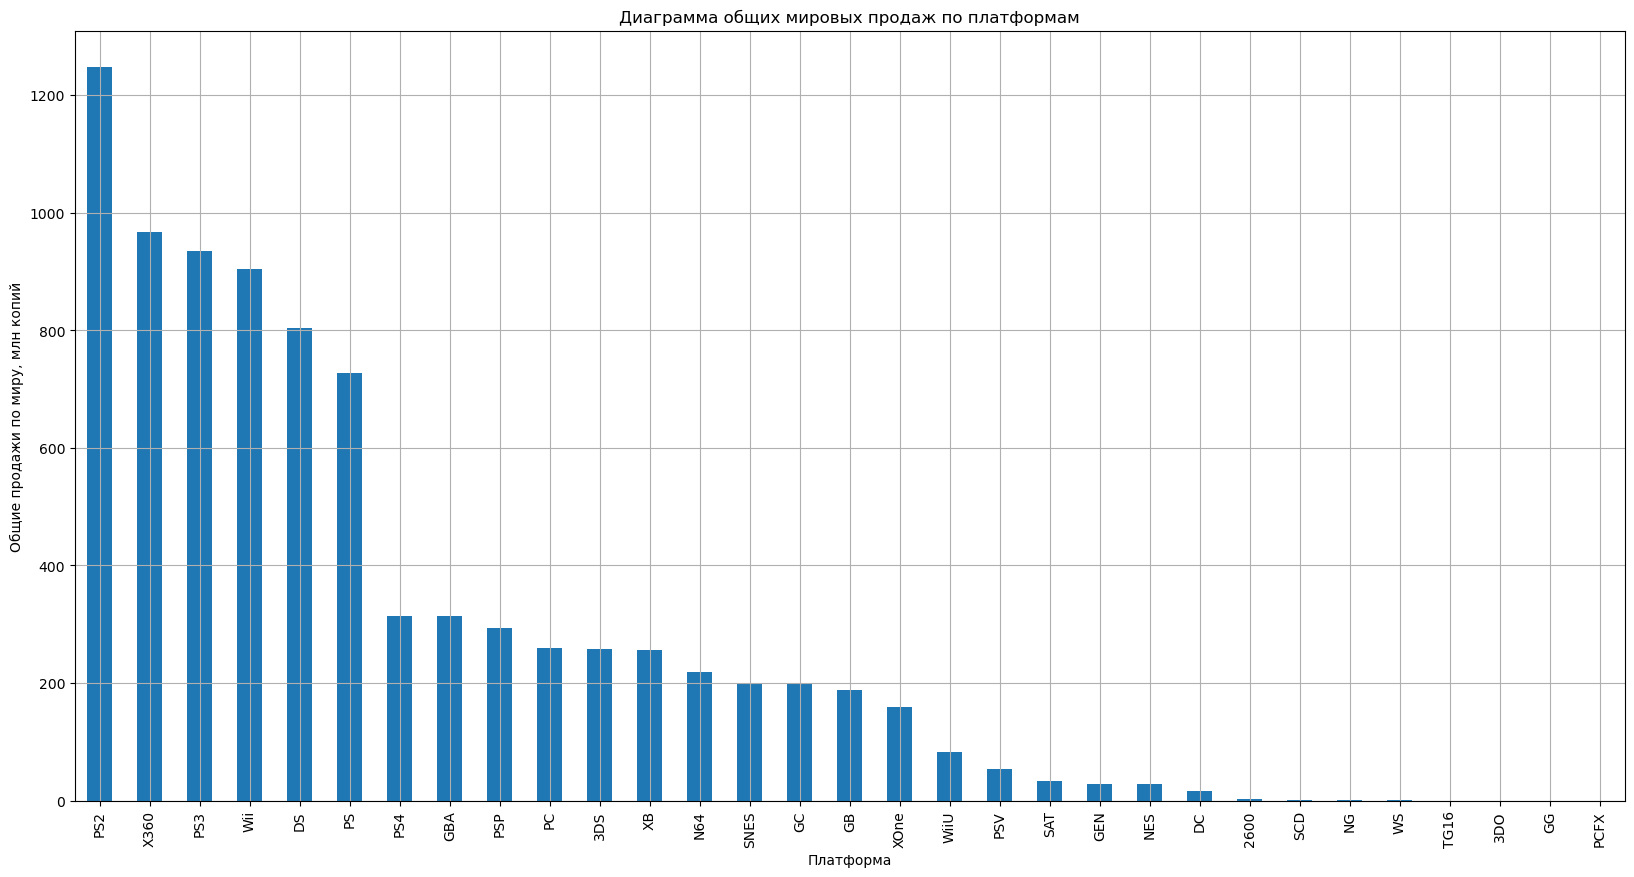

In [112]:
(
    filtered_data.groupby('platform')
                 ['total_sales']
                 .sum()
                 .sort_values(ascending=False)
                 .plot(
                     kind="bar",
                     title='Диаграмма общих мировых продаж по платформам',
                     figsize=(20, 10),
                     ylabel='Общие продажи по миру, млн копий',
                     xlabel='Платформа',
                     grid=True
                 )
)
plt.show()

По графику видно, что наиболее популярными платформами были PS2, X360, PS3, Wii и DS. **Можно также заметить, что наиболее популярной линейкой платформ были платформы PS**.

Выделим наиболее популярные платформы (первый пять по количеству суммарных продаж) и выясним среднее время "жизни" платформы. Для этого создадим сводную таблицу с первым и последним годом продаж игр на каждой платформе. Возьмем только популярные платформы, так как в выборке присутсвуют платформы с небольшим сроком жизни

In [113]:
# Наиболее популярные платформы
top_sales_per_platform = (
    filtered_data.groupby('platform')
                 ['total_sales']
                 .sum()
                 .sort_values(ascending=False)
                 .head()
)

# Создаем сводную таблицу
mean_lifetime_per_platform = (
                                filtered_data
                                        .query('platform in @top_sales_per_platform.index')
                                        .pivot_table(
                                                    index='platform',
                                                    values='year_of_release',
                                                    aggfunc=['min', 'max']
                                                   )
                             )
# Переименовываем столбцы для наглядности
mean_lifetime_per_platform.columns=['first_year', 'last_year']
# Считаем время жизни платформы (разница между первой вышедшей на платформе игрой и последней)
mean_lifetime_per_platform['lifetime'] = mean_lifetime_per_platform['last_year'] - mean_lifetime_per_platform['first_year']
# Проверка
mean_lifetime_per_platform

,first_year,last_year,lifetime
platform,,,
DS,2004,2013,9
PS2,1997,2011,14
PS3,1991,2016,25
Wii,2006,2016,10
X360,2005,2016,11


In [114]:
print(f'Среднее время жизни платформы составляет: {mean_lifetime_per_platform["lifetime"].median():.0f} лет')

Среднее время жизни платформы составляет: 11 лет


Таким образом, в среднем платформы сменяются раз в 11 лет. При этом на обзем графике видно, что до 2000 года было очень много консолей с малым сроком жизни.

В 2015-2016 годах появились новые поколения платформ, из-за этого кол-во игр на платформах прошлого поколения будет снижатся, а продажи игр, выходящих на новых поколениях будут повышаться.

**Из данного наблюдения следует, что для прогнозирования продаж на 2017 нужно взять период 2014-2016 года (2014 тоже нужно взять, так как за 2016 год данные не полные и дадут погрешность)**

Также отмечу, что по выводу выше и общему графику в начале блока можно заметить, что старые платформы заканчивают свои сроки жизки. **Значит в продажах 2017 года будут фигугироровать только самые актуальные платформы** 

Создадим новый фрейм по данному условию  и найдем актуальные платформы

In [115]:
actual_data = filtered_data.query('year_of_release > 2013')

Создадим и исследуем график общих продаж игр по платформам, чтобы понять тенденции продаж данного периода

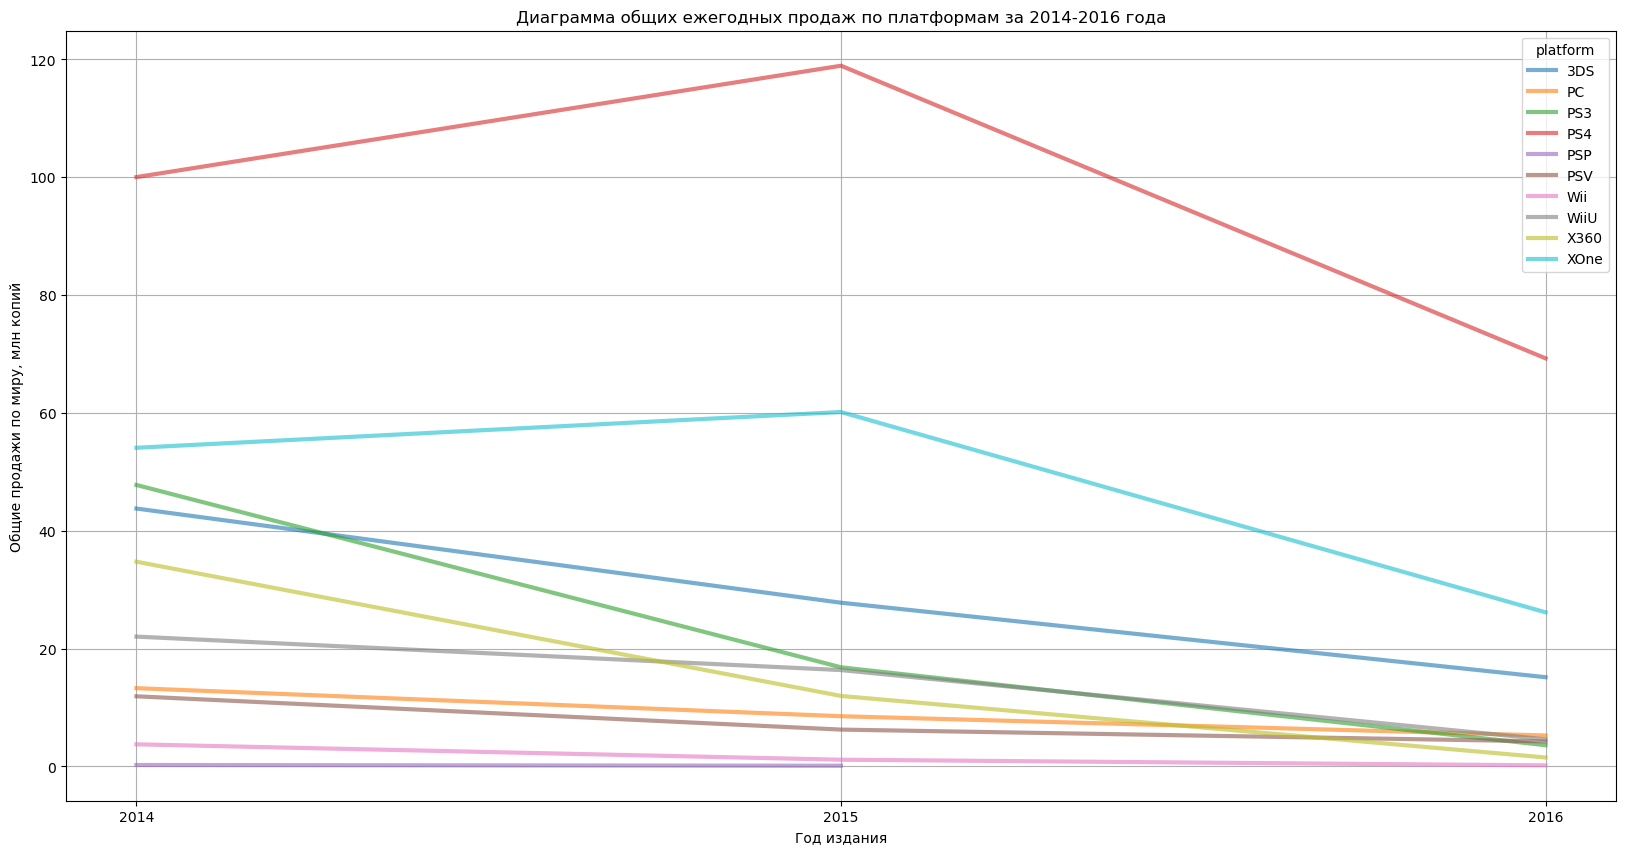

In [116]:
(
    actual_data.groupby(['year_of_release', 'platform'])
               ['total_sales']
               .sum()
               .unstack()
               .plot(
                     kind="line",
                     title='Диаграмма общих ежегодных продаж по платформам за 2014-2016 года',
                     lw=3,
                     alpha=0.6,
                     figsize=(20, 10),
                     xticks=actual_data['year_of_release'].unique(),
                     ylabel='Общие продажи по миру, млн копий',
                     xlabel='Год издания',
                     grid=True
                 )
)
plt.show()

По графику видно, что продажи растут у платформ PS4, XOne (спад в 2016 объясняется незаконченным периодом). Продажи падают у платформ старого поколения. Отдельно стоит отметить PC, так как игры на данной платформе стабильно продаются на протяжении 25 лет и тенденция будет сохраняться в 2017.

**Продажи игр на консолях старого поколения снижаются, когда продажи на платформах нового поколения растут.**

Также стоит отметить три потенциально прибыльных платформы PC, PS, Xbox. Остальные платформы можно исключить в дальнейшем анализе.

In [117]:
# Выделяем потенциально прибыльные платформы
actual_platforms = ['PC', 'PS4', 'XOne']

actual_data = actual_data.query('platform in @actual_platforms')

Создадим диаграму размаха по глобальным продажам игр в разбивке по платформам. Воспользуемся методом groupby()

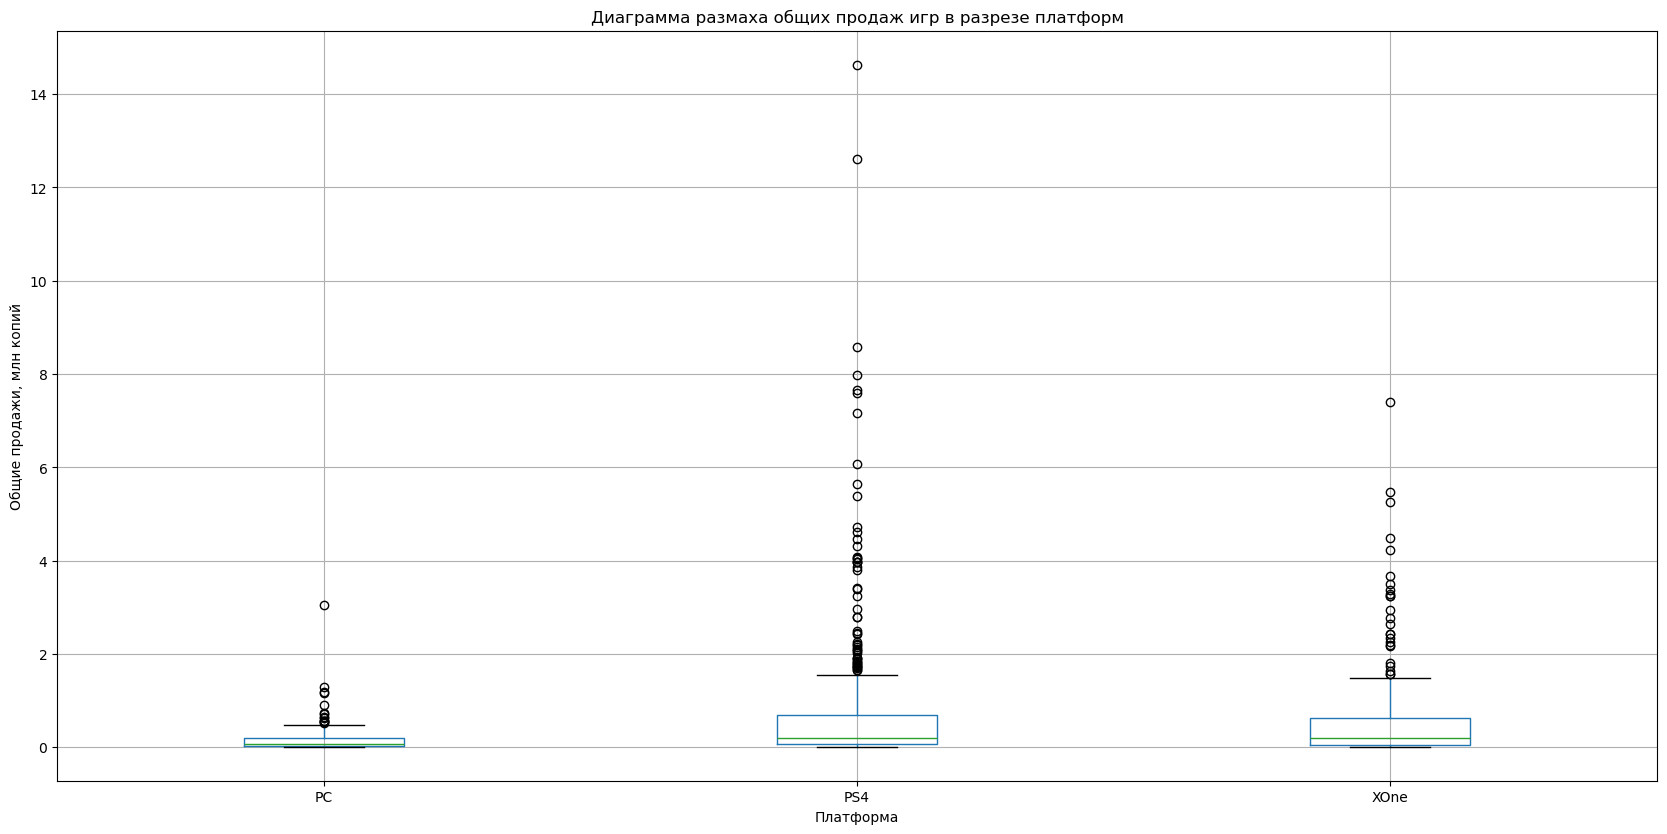

In [118]:
bxpt = actual_data.boxplot(
    column='total_sales',
    by='platform',
    fontsize=10,
    figsize=(20, 10)
)

bxpt.plot()

plt.title('Диаграмма размаха общих продаж игр в разрезе платформ')
plt.suptitle('')
plt.ylabel('Общие продажи, млн копий')
plt.xlabel('Платформа')

plt.show()

По графику видно, что есть очень много выбросов. Стоит ограничить график по высоте: от 0 до 8 млн копий (так как значений выше 8 млн проданных копий не так много)

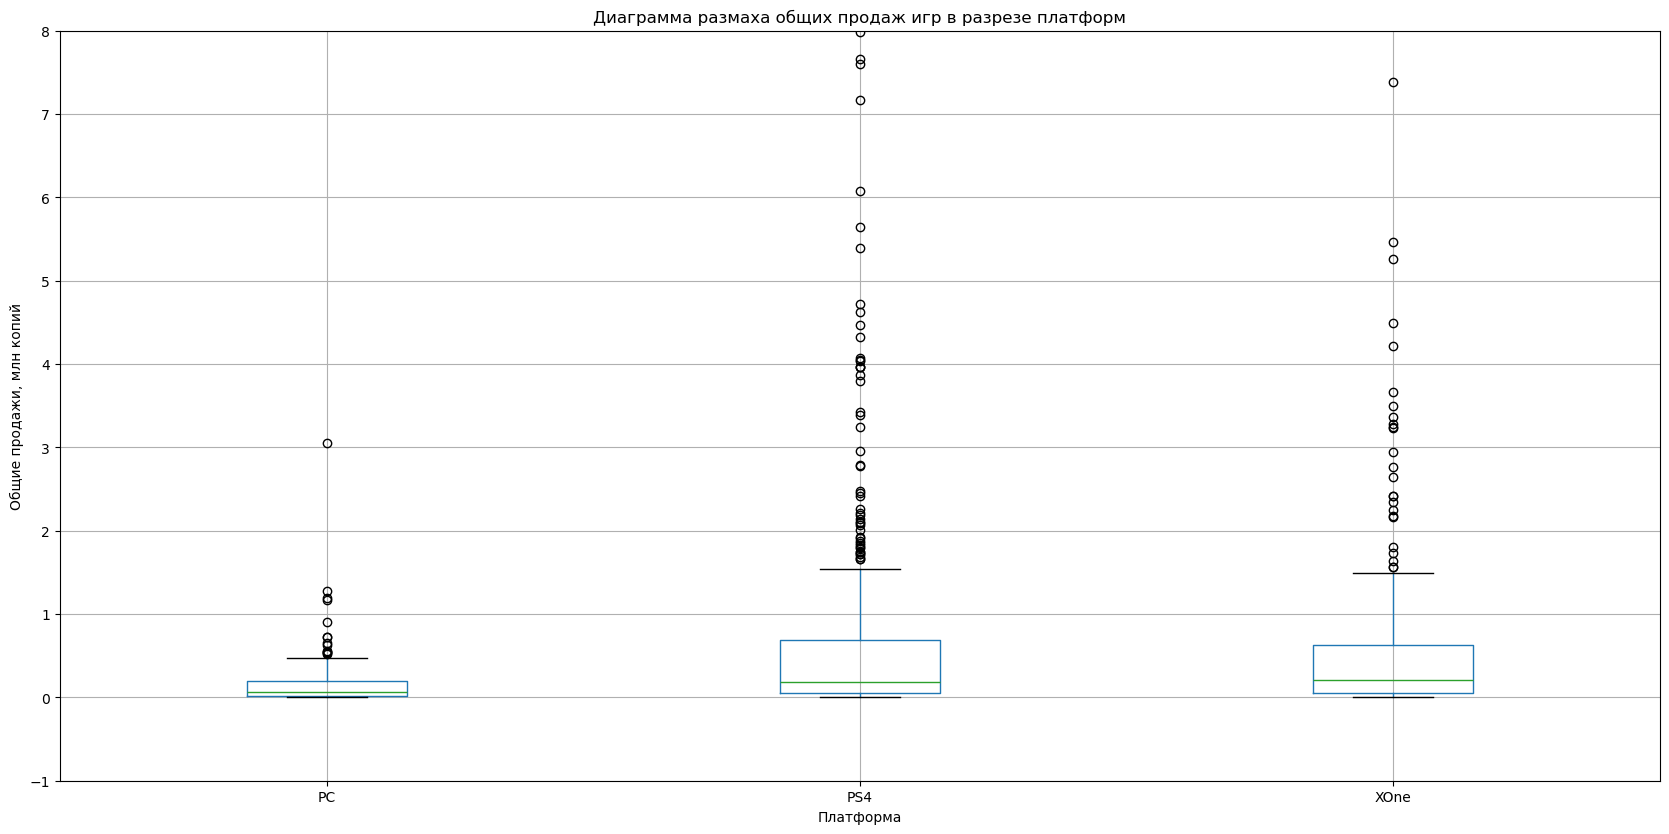

In [119]:
bxpt = actual_data.boxplot(
    column='total_sales',
    by='platform',
    fontsize=10,
    figsize=(20, 10)
)

bxpt.plot()

plt.title('Диаграмма размаха общих продаж игр в разрезе платформ')
plt.suptitle('')
plt.ylabel('Общие продажи, млн копий')
plt.xlabel('Платформа')
plt.ylim(-1, 8)

plt.show()

На данном графике видно, что средние продажи игр на платформах старого поколения ниже, чем на новых (высота квартилей меньше). Также средние продажи игр на платформу PC очень малы и близки к 0. Для дальнейшего исследования уберем игры, продажи которых выше 8 млн копий

In [120]:
actual_data = actual_data.query('total_sales <= 8')

Посмотрим, как влияют на продажи внутри наиболее продаваемой платформы отзывы пользователей и критиков. Построим диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами.

Коэффициент корреляции между общими продажами игр платформы PS4 и оценкой критиков на них составляет:     0.3937


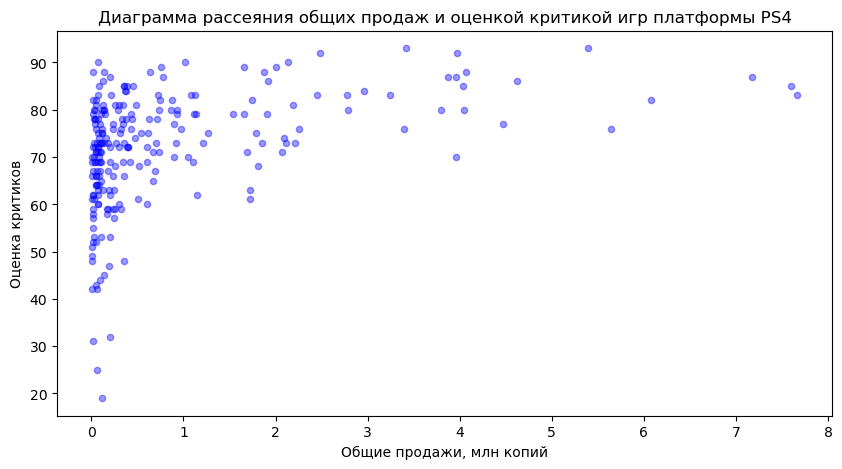

Коэффициент корреляции между общими продажами игр платформы PS4 и оценкой пользователей на них составляет:     -0.0472


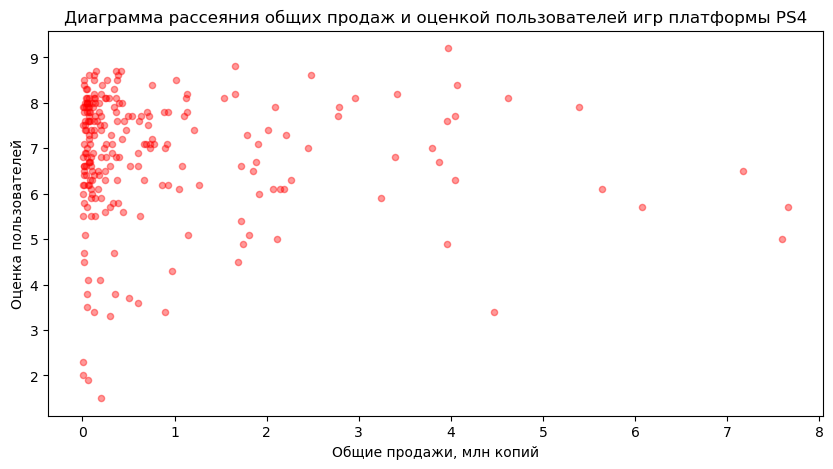

Коэффициент корреляции между общими продажами игр платформы XOne и оценкой критиков на них составляет:     0.4221


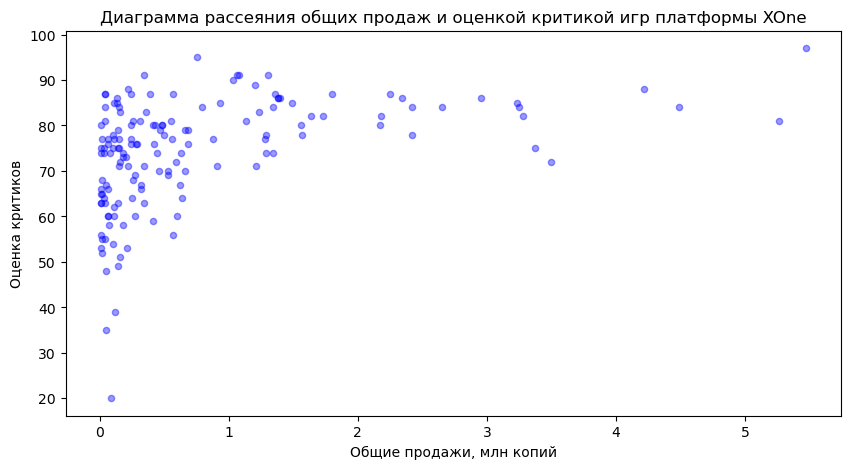

Коэффициент корреляции между общими продажами игр платформы XOne и оценкой пользователей на них составляет:     -0.0917


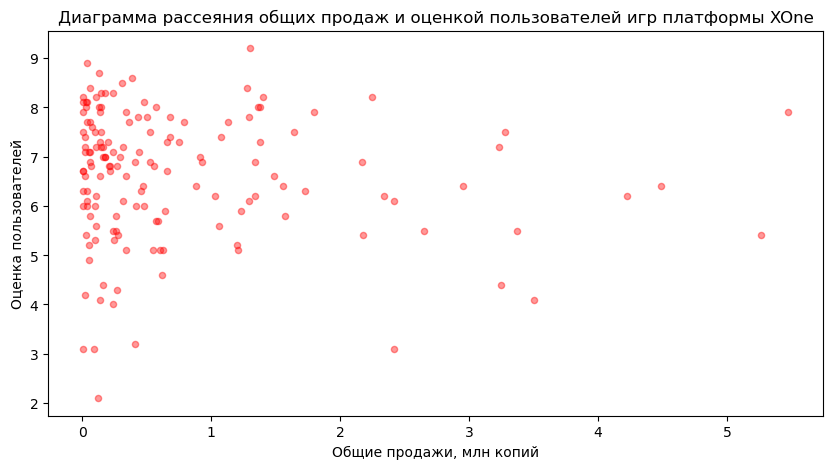

Коэффициент корреляции между общими продажами игр платформы PC и оценкой критиков на них составляет:     0.1721


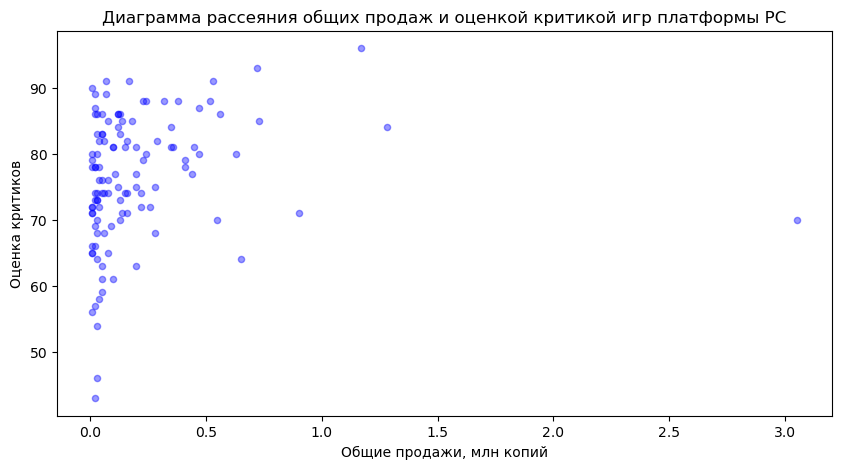

Коэффициент корреляции между общими продажами игр платформы PC и оценкой пользователей на них составляет:     -0.0900


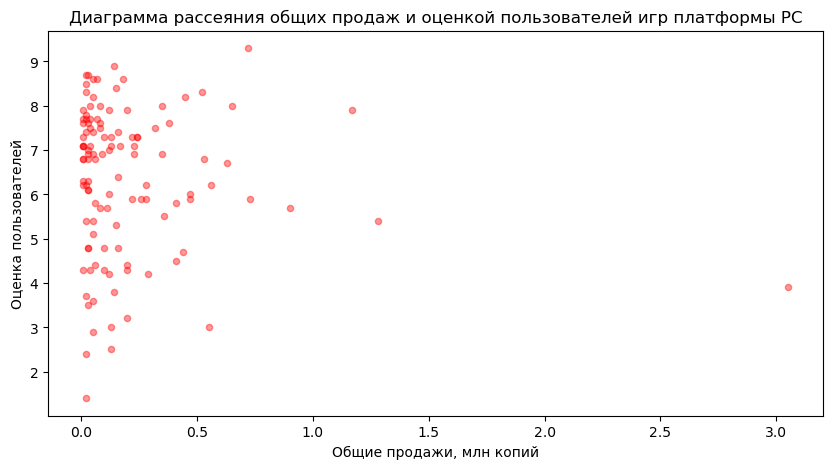

In [121]:
# Выделяем данные в отдельный фрейм
top_sales_platforms_data = actual_data.query('not critic_score.isna() and not user_score.isna()')

# Создаем цикл, где проходим по каждой платформе, выводя результат
for platform in top_sales_platforms_data['platform'].unique():
    platform_data = top_sales_platforms_data.query('platform == @platform')
    # 1) По отзывам критиков
    # Диаграмма
    platform_data.plot(
        kind='scatter',
        x='total_sales',
        y='critic_score',
        color='blue',
        alpha=0.4,
        title=f'Диаграмма рассеяния общих продаж и оценкой критикой игр платформы {platform}',
        figsize=(10, 5),
        xlabel='Общие продажи, млн копий',
        ylabel='Оценка критиков'
    )
    # Коэффициент корреляции
    print(f'Коэффициент корреляции между общими продажами игр платформы {platform} и оценкой критиков на них составляет: \
    {platform_data["total_sales"].corr(platform_data["critic_score"]):.4f}')
    plt.show()


    # 2) По отзывам пользователей
    platform_data.plot(
        kind='scatter',
        x='total_sales',
        y='user_score',
        color='red',
        alpha=0.4,
        title=f'Диаграмма рассеяния общих продаж и оценкой пользователей игр платформы {platform}',
        figsize=(10, 5),
        xlabel='Общие продажи, млн копий',
        ylabel='Оценка пользователей'
    )

    print(f'Коэффициент корреляции между общими продажами игр платформы {platform} и оценкой пользователей на них составляет: \
    {platform_data["total_sales"].corr(platform_data["user_score"]):.4f}')
    
    plt.show()

Таким образом для данных платформ не видна сильная корреляция ни между оценкой критиков, ни между оценкой пользователей (коэффициенты корреляции менее 0.5).
На шаге 2 уже был посчитан общий коэффициент корреляции, он также доказывает следующий вывод.

**Зависимости между оценкой критиков/пользователей и общими продажами нет**

Найдем наиболее популярные жанры игр. Для этого следует проверить найти мединные и средние продажи жанров и оценить соотношение

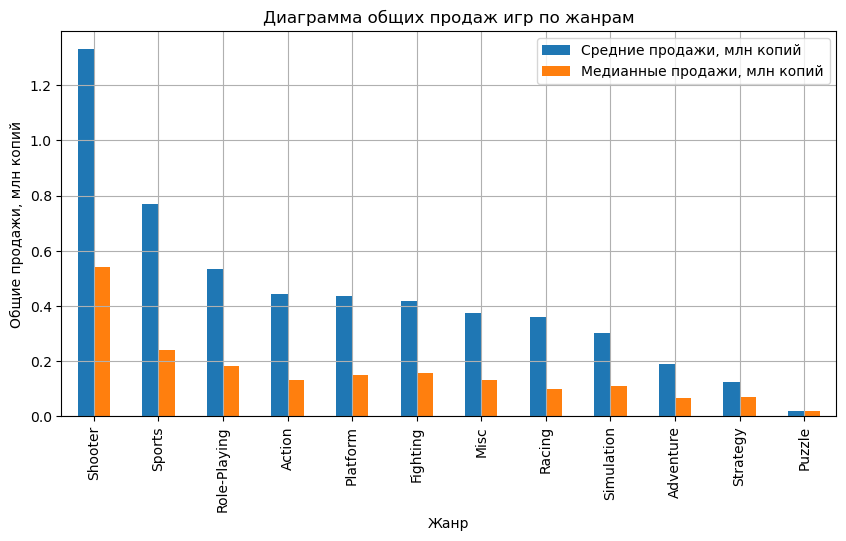

In [122]:
(
    # Строим сводную таблицу средних и медианных общих продаж игр
    actual_data.pivot_table(index='genre', values='total_sales', aggfunc=['mean', 'median'])
               # Убираем тех наименования колонок
               .droplevel(1, axis=1)
               # Сотрируем таблицу
               .sort_values(by='mean', ascending=False)
               # Строим график
               .plot(kind='bar',
                     title='Диаграмма общих продаж игр по жанрам',
                     xlabel='Жанр',
                     ylabel='Общие продажи, млн копий',
                     grid=True,
                     figsize=(10, 5)
                    )
)

plt.legend(['Средние продажи, млн копий', 'Медианные продажи, млн копий'])
plt.show()

По графику видно, что наиболее прибыльным жанром является жанр Shooter, наименее - "Puzzle"

**Итог:**
- Среднее время жизни консоли - 11 лет. Актальным периодом для прогнозирвоания продаж на 2017 год является 2014-2016 года.
- Основными платформами будут PS4, XOne. Также стабильно игры будут продаваться на PC
- Взаимосвязи между кол-вом проданных копий и оценкой критиков/пользователей не обнаружено
- Наиболее прибыльным жанром является жанр Shooter, наименее - "Puzzle"

## Портрет пользователя каждого региона

Для каждого из трех регионов (NA, EU, JP) выведем наиболее популярные жанры игр и платформы.<br>Создадим вспомогательную функцию для вывода топ-5 жанров

In [123]:
# Служебный массив
regions = ['na_sales', 'eu_sales', 'jp_sales']

# Служебная функция
def dispay_top_per_region(top_type_column, top_type_string, length):
    # Создаем сводную таблицу по указанной колонке
    pivot_table = actual_data.pivot_table(index=top_type_column, values=regions, aggfunc='sum')
    # Циклом проходимся по каждому региону
    for region in regions:
        # Выбираем необходимый регион из сводной таблицы, сортируем продажи по убыванию и вытаскиваем индексы
        region_sales = pivot_table[region].sort_values(ascending=False)
        total_region_sales = pivot_table[region].sum()
        print(f'Топ-5 {top_type_string} по регионy {region[:2].upper()}:')
        for i in range(length):
            # Выводим первые пять мест + доля продаж
            print(f'{i+1} место - {region_sales.index[i]} ({region_sales[i] / total_region_sales:,.2%})')
        region_sales.plot(kind='pie',
                          label='',
                          autopct=lambda v: f'{v:.2f}%' if v > 5 else None,
                          title=f'Распреление {top_type_string} по регионy {region[:2].upper()}')
        plt.show()
        print()

Топ-5 платформ по регионy NA:
1 место - PS4 (49.72%)
2 место - XOne (46.18%)
3 место - PC (4.11%)


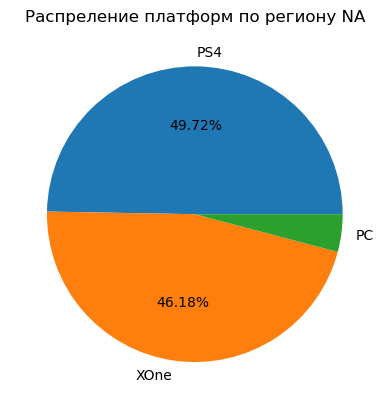


Топ-5 платформ по регионy EU:
1 место - PS4 (63.51%)
2 место - XOne (26.28%)
3 место - PC (10.21%)


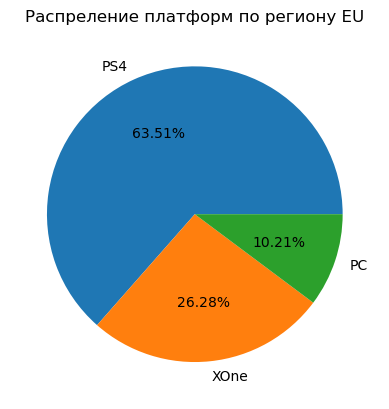


Топ-5 платформ по регионy JP:
1 место - PS4 (97.80%)
2 место - XOne (2.20%)
3 место - PC (0.00%)


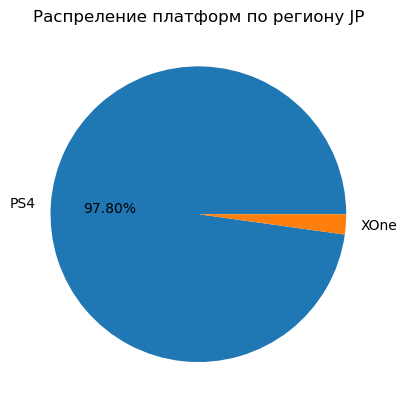

In [124]:
# Платформы
dispay_top_per_region('platform', 'платформ', 3)

Во всех регионах наблюдается одинаковый топ платформ. Наиболее продаваемой платформой стала PS4

Топ-5 жанров игр по регионy NA:
1 место - Shooter (33.07%)
2 место - Action (26.28%)
3 место - Sports (17.12%)
4 место - Role-Playing (9.80%)
5 место - Misc (4.12%)


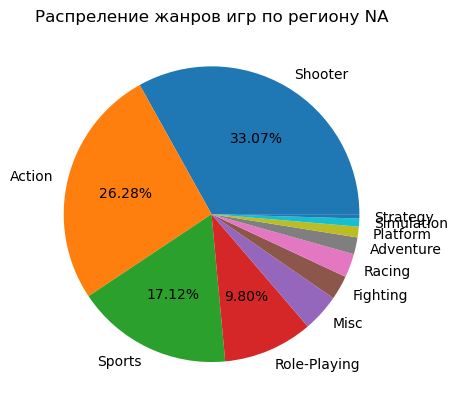


Топ-5 жанров игр по регионy EU:
1 место - Shooter (27.81%)
2 место - Action (27.59%)
3 место - Sports (14.88%)
4 место - Role-Playing (10.31%)
5 место - Racing (6.11%)


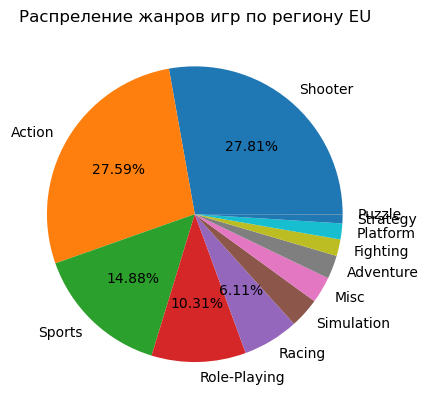


Топ-5 жанров игр по регионy JP:
1 место - Action (37.76%)
2 место - Role-Playing (24.48%)
3 место - Shooter (15.89%)
4 место - Sports (5.71%)
5 место - Fighting (5.23%)


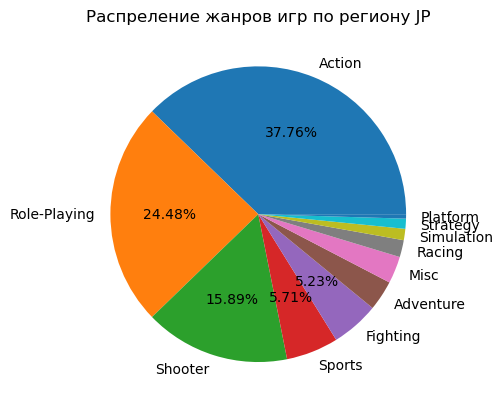

In [125]:
dispay_top_per_region('genre', 'жанров игр', 5)

Видно, что топ-4 продаж по регионам NA и EU идентичный с небольшими разницами в долях. Наиболее полпулярный жанр - Shooter<br>
Топ-4 жанров в регионе JP отличается от вышеуказанных лишь долями. Наиболее популярный жанр в данном регионе - Action

Проверим также, влияет ли рейтинг ESRB на продажи в каждом регионе. Для этого создадим графики продаж, по каждому региону в разрезе рейтинга ERSB (воспользуемся созданным служебным столбцом)

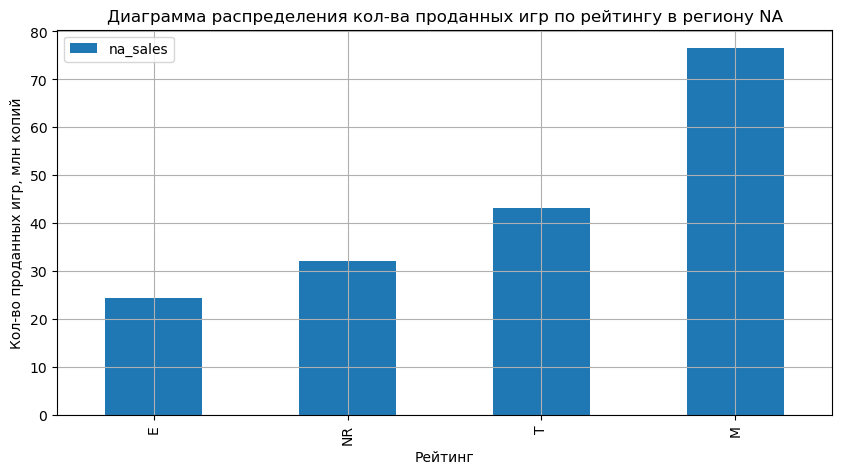

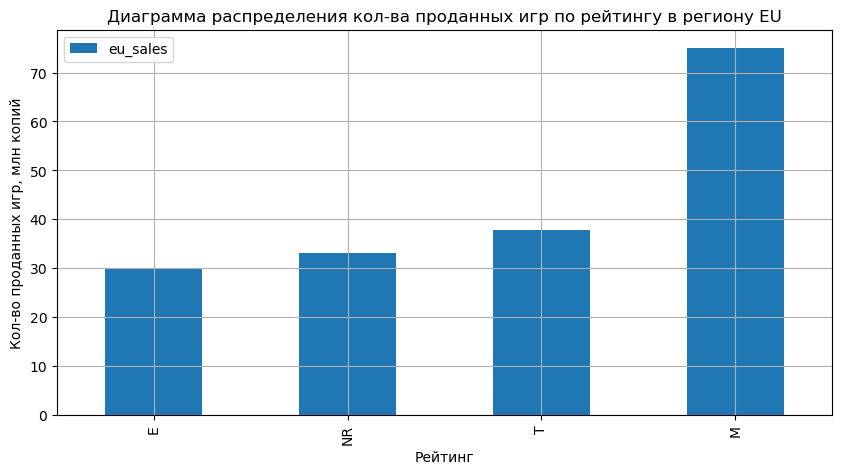

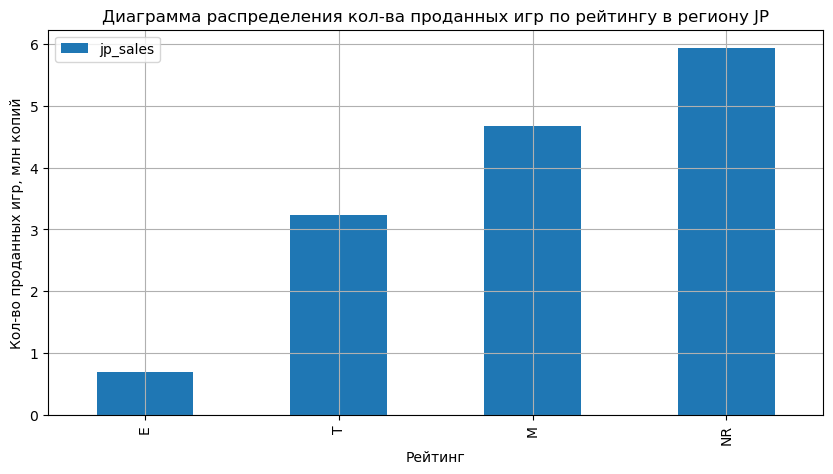

In [126]:
for region in regions:
    # Строим сводную таблицу, по этим данным строим график
    (
        actual_data.pivot_table(index='rating', values=region, aggfunc='sum')
                     .sort_values(by=region)
                     .plot(kind='bar',
                           grid=True,
                           title=f'Диаграмма распределения кол-ва проданных игр по рейтингу в региону {region[:2].upper()}',
                           figsize=(10, 5),
                           ylabel='Кол-во проданных игр, млн копий',
                           xlabel='Рейтинг')
    )

По данным графикам можно сделать вывод, что **рейтинг ESRB влияет на продажи**:
- Наиболее продаваемым был рейтинг M (Не считая технический рейтинг NR)
- В JP больше всего игр без указанного рейтинга (скорее всего связано с большим количеством "маленьких" игр, которым нет смысла выставлять рейтинг)
- Менее популрным рейтингом стал E

Данные выводы подтверждаются топом продаж по жанрам: наиболее продаваемые жанры - Shooter, Action, Role-Playing - жанры с более частыми рейтингами T и M

**Итог:**<br>
На 2017 год стоит сделать ставку на игру жанра Shooter, для платформы PS4 (больше всего продаж во всех регионах на платформах данного бренда), с рейтингом M (для всех)

## Проверка гипотез

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые
**Нулевая гипотеза:** средний рейтинг пользователей игр на платформе XOne равен среднему рейтингу пользователей платформы на PC<br>
**Альтернативная гипотеза:** средний рейтинг пользователей игр на платформе XOne не равен среднему рейтингу пользователей платформы на PC

Для проверки этих гипотез необходимо воспользоваться ttest_ind(). Уровень значимости примем за 5%. Альтернативную гипотезу мы можем не указывать.

In [127]:
# Уровень значимости
alpha = 0.05

In [128]:
# Получим результат
pvalue_1 = st.ttest_ind(
    # Выберем лишь игры на платформе XOne, возьмем их рейтинги пользователей, убрав пустоты
    actual_data.query('platform == "XOne"')['user_score'].dropna(),
    # Аналогично
    actual_data.query('platform == "PC"')['user_score'].dropna()
).pvalue

print("Среднее значение оценки пользователей платформы XOne: ", actual_data.query('platform == "XOne"')['user_score'].dropna().mean())
print("Среднее значение оценки пользователей платформы PC: ", actual_data.query('platform == "PC"')['user_score'].dropna().mean())
print('p-значение:', pvalue_1)
if pvalue_1 < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

Среднее значение оценки пользователей платформы XOne:  6.594545454545456
Среднее значение оценки пользователей платформы PC:  6.298360655737705
p-значение: 0.10450507919348401
Не получилось отвергнуть нулевую гипотезу


Получилось, что **средние пользовательские рейтинги игр на платформе XOne равны средним пользовательским рейтингам игр на платформе PC.** Возможно, это связано с тем, что XOne - более новая платформа, на которую вышло еще не так много игр, когда PC - самая старая платформа, на которую ежегодно выходят игры, но при этом XOne более популярная платформа, с большим кол-вом продаж

### Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.
**Нулевая гипотеза:** средний рейтинг пользователей игр жанра Action равен среднему рейтингу пользователей жанра Sports<br>
**Альтернативная гипотеза:** средний рейтинг пользователей игр жанра Action не равен среднему рейтингу пользователей жанра Sports

In [129]:
# Получим результат
pvalue_2 = st.ttest_ind(
    # Выберем лишь игры жанра Action, возьмем их рейтинги пользователей, убрав пустоты
    filtered_data.query('genre == "Action"')['user_score'].dropna(),
    # Аналогично
    filtered_data.query('genre == "Sports"')['user_score'].dropna()
).pvalue

print("Среднее значение оценки пользователей жанра Action: ", actual_data.query('genre == "Action"')['user_score'].dropna().mean())
print("Среднее значение оценки пользователей жанра Sports: ", actual_data.query('genre == "Sports"')['user_score'].dropna().mean())
print('p-значение:', pvalue_2)

# Будем использовать знак "больше или равно", так как нам нужно проверить обратную гипотезу
if pvalue_2 < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

Среднее значение оценки пользователей жанра Action:  6.741176470588235
Среднее значение оценки пользователей жанра Sports:  5.623076923076923
p-значение: 0.0844413724483731
Не получилось отвергнуть нулевую гипотезу


Значит, **средний рейтинг пользователей игр жанра Action равен среднему рейтингу пользователей жанра Sports**. Это может быть связано с популярностью жанров

## Общий вывод

В данной работе были исследованы рейтинги и продажи игр, вышедших с 1984 по 2016 года.<br>
Данные были обработаны:
- убраны дубликаты, пустоты
- заменены названия столбцов
- приведены типы к нужным<br>

Для прогнозирования продаж на 2017 год необходимо изучить продажи за 2006-2016 года. Данный период взят исходя из средней продолжительности жизни платформы.Основными платформами будут PS4, XOne. Также стабильно игры будут продаваться на PC. 

Взаимосвязи между кол-вом проданных копий и оценкой критиков/пользователей не обнаружено. 

Наиболее продаваемым жанром игр в выбранный период был жанр "Shooter", наименее продаваемым - "Adventure"

На 2017 год стоит сделать ставку на игру жанра Shooter (популярна в регионах NA и EU, наибольшие продажи) или Role-playing (Входит в топ-5 продадаж по регионам NA и EU, наиболее популярна в регионе JP), для платформы PS4 (больше всего продав во всех регионах на платформах данного бренда), с рейтингом E (для всех)<br>
Также были проверены две гипотезы:
- средние пользовательские рейтинги игр на платформе XOne равны средним пользовательским рейтингам игр на платформе PC
- средний рейтинг пользователей игр жанра Action равен среднему рейтингу пользователей жанра Sports